<p align="center">
  <img height="100" src="https://raw.githubusercontent.com/arguflow/blog/5ef439020707b0e27bf901c8f6b4fb1f487a78d4/apps/frontend/public/assets/horizontal-logo.svg" alt="Arguflow">
</p>

<p align="center">
    <b>Offering a product suite for putting arbitrary models into production semantic search and retrieval-augmented LLM-chat experiences on your company's data</b>
</p>

<p align="center">
<strong><a href="https://docs.arguflow.ai">Documentation</a> • <a href="https://search.arguflow.ai">Competitive Debate Search Demo</a> • <a href="https://chat.arguflow.ai">Competitive Debate Chat Demo</a> • <a href="https://discord.gg/CuJVfgZf54">Discord</a>

</strong>
</p>


# Exploring replacing our SVD (qdrant) with Clickhouse

The objective behind this notebook was to assess the feasibility of substituting our system's SVD, [Qdrant](https://qdrant.tech/), with [Clickhouse](https://clickhouse.com/). Employing ClickHouse would offer the advantage of utilizing a comprehensive DBMS, thereby eliminating the need for external database joins during diverse search operations.

## Findings

The key takeaway here is that we are strategically developing our systems to facilitate seamless replacement of the underlying vector store. Anticipating the uncertain trajectory of vector store solutions, we're exercising caution and refraining from fully committing to any particular data store solution at this point.

For now, we will stick to [Qdrant](https://qdrant.tech/) for our competitive debate demos as [Clickhouse](https://clickhouse.com/)'s [annoy index](https://clickhouse.com/docs/en/engines/table-engines/mergetree-family/annindexes) is too imprecise to be viable.

However, it is important to note that Clickhouse wins out on pure speed and can be the right choice for datasets characterized by substantial sparsity or considerable size. We may use Clickhouse for future customer deployments when it makes sense to do so.

### Replicating our results

1. Download the dataset via [this link](https://drive.proton.me/urls/FED1ABWG70#ItjHZqiPpUao). This is roughly the [DebateSum dataset](https://aclanthology.org/2020.argmining-1.1/), but with some improved parsing loggic and dedup detection as noted on [our docs](https://docs.arguflow.ai).
2. Place the dataset into the same directory as this notebook
3. `docker compose up -d`
4. `cat .env.dist > .env`
4. Run all to duplicate our findings

In [21]:
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from qdrant_client.http import models

# Load values from the .env file
load_dotenv()

# Get values from the environment variables
qdrant_url = os.getenv("QDRANT_URL")
qdrant_api_key = os.getenv("QDRANT_API_KEY")

# Create the QdrantClient instance
qdrant_client = QdrantClient(
    url=qdrant_url,
    api_key=qdrant_api_key,
)

qdrant_client.recreate_collection(
    collection_name="debate_cards",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE),
)

/home/skeptrune/.local/lib/python3.10/site-packages/qdrant_client/qdrant_remote.py:115: UserWarning: Api key is used with unsecure connection.
  warnings.warn("Api key is used with unsecure connection.")


True

In [22]:
import clickhouse_connect

clickhouse_client = clickhouse_connect.get_client()
clickhouse_client.server_version

'23.3.9.55'

In [23]:
import pickle

# Load the dataset from the pickle file
pickle_filename = "dataset.pickle"
with open(pickle_filename, "rb") as pickle_file:
    loaded_dataset = pickle.load(pickle_file)


In [24]:
qdrant_count = qdrant_client.count(
    collection_name="debate_cards",
    exact=True,
)

if qdrant_count.count > 0:
    print("Collection is not empty, exiting")
else:
    # add to qdrant 1k at a time
    for i in range(0, len(loaded_dataset), 1000):
        qdrant_client.upsert(
            collection_name="debate_cards",
            points=models.Batch(
                ids=[item[0] for item in loaded_dataset[i:i+1000]],
                vectors=[item[1] for item in loaded_dataset[i:i+1000]]
            ),
        )

qdrant_client.count(
    collection_name="debate_cards",
    exact=True,
)

CountResult(count=255070)

In [25]:
delete_table_query = """
DROP TABLE IF EXISTS qdrant_point_ids
"""

clickhouse_client.query(delete_table_query)

create_table_query = """
CREATE TABLE IF NOT EXISTS qdrant_point_ids
(
    `point_id` String,
    `embedding_vector` Array(Float32),
)
ENGINE = MergeTree
ORDER BY point_id
"""

clickhouse_client.query(create_table_query)

offset = ""

while offset is not None:
    scroll_result = qdrant_client.scroll(
        collection_name="debate_cards",
        limit=100,
        with_vectors=True,
        offset=(offset if offset else None),
    )

    offset = scroll_result[1]

    insert_found_points_query = """
        INSERT INTO qdrant_point_ids
        VALUES
        """
    
    for point in scroll_result[0]:
        insert_found_points_query += f"('{point.id}', {point.vector}),"

    clickhouse_client.query(insert_found_points_query)

In [26]:
import time


base_count = 0
while base_count != 255070:
    get_qdrant_point_ids_count_query = """
    SELECT COUNT(*)
    FROM qdrant_point_ids
    """
    base_count = clickhouse_client.query(get_qdrant_point_ids_count_query).result_rows[0][0]

    time.sleep(1)


ch_tables = [1, 10, 100]

allow_experimental_indexes_query = """
SET allow_experimental_annoy_index = 1
"""

clickhouse_client.query(allow_experimental_indexes_query)

for ch_table in ch_tables:
    drop_table_query = f"""
    DROP TABLE IF EXISTS qdrant_benchmark_{ch_table}
    """
    clickhouse_client.query(drop_table_query)

    create_table_query = f"""
    CREATE TABLE IF NOT EXISTS qdrant_benchmark_{ch_table} (
        `point_id` String,
        `embedding_vector` Array(Float32),
        INDEX annoy_embedding_vector embedding_vector TYPE annoy(100, 'cosineDistance') GRANULARITY {ch_table},
    )
    ENGINE = MergeTree()
    ORDER BY point_id
    """
    clickhouse_client.query(create_table_query)

    insert_points_query = f"""
    INSERT INTO qdrant_benchmark_{ch_table}
    SELECT * FROM qdrant_point_ids
    """

    clickhouse_client.query(insert_points_query)

In [27]:
for ch_table in ch_tables:
    temp_count = 0
    while temp_count != base_count:
        get_qdrant_point_ids_count_query = f"""
        SELECT COUNT(*)
        FROM qdrant_benchmark_{ch_table}
        """
        temp_count = clickhouse_client.query(get_qdrant_point_ids_count_query).result_rows[0][0]

        time.sleep(1)

In [28]:
scroll_result = qdrant_client.scroll(
    collection_name="debate_cards",
    limit=100,
    with_vectors=True,
)

first_100_qdrant_vectors = [point.vector for point in scroll_result[0]]

In [29]:
import numpy as np
import timeit

qdrant_search_times = []
ch_qdrant_point_ids_search_times = []
ch_benchmark_search_times = {}
for ch_table in ch_tables:
    ch_benchmark_search_times[ch_table] = []


for i in range(100):
    query_vector = np.random.rand(1536).astype(np.float32).tolist()

    for ch_table in ch_tables:
        ch_mid_cosine_similarity_query = f"""
        SELECT
            point_id,
            cosineDistance(embedding_vector, {query_vector}) AS score
        FROM qdrant_benchmark_{ch_table}
        ORDER BY score ASC
        LIMIT 10
        """

        ch_benchmark_search_times[ch_table].append(timeit.timeit(lambda: clickhouse_client.query(ch_mid_cosine_similarity_query), number=1))

    ch_qdrant_point_id_query = f"""
    SELECT
        point_id,
        cosineDistance(embedding_vector, {query_vector}) AS score
    FROM qdrant_point_ids
    ORDER BY score ASC
    LIMIT 10
    """
    ch_qdrant_point_ids_search_times.append(timeit.timeit(lambda: clickhouse_client.query(ch_qdrant_point_id_query), number=1))

    qdrant_search_times.append(timeit.timeit(lambda: qdrant_client.search(collection_name="debate_cards", query_vector=query_vector, limit=10, search_params={"exact": True}), number=1))

    

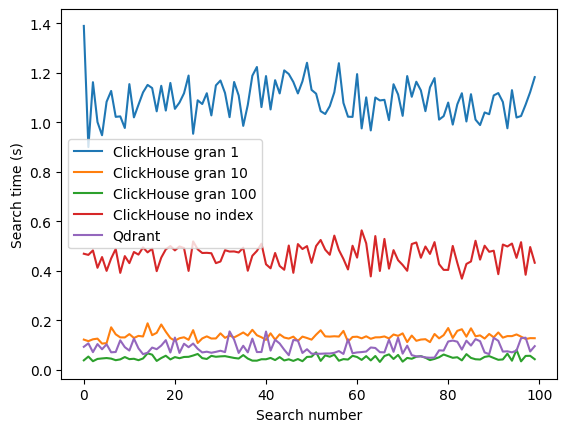

In [30]:
# plot the results

import matplotlib.pyplot as plt

for ch_table in ch_tables:
    plt.plot(ch_benchmark_search_times[ch_table], label=f"ClickHouse gran {ch_table}")

plt.plot(ch_qdrant_point_ids_search_times, label="ClickHouse no index")
plt.plot(qdrant_search_times, label="Qdrant")

plt.xlabel("Search number")
plt.ylabel("Search time (s)")
plt.legend()
plt.show()

In [31]:
# Get avg, max, min search time for ClickHouse
[ch_avg_search_time, ch_max_search_time, ch_min_search_time] = [np.mean(ch_qdrant_point_ids_search_times), np.max(ch_qdrant_point_ids_search_times), np.min(ch_qdrant_point_ids_search_times)]
# Get avg, max, min search time for Qdrant
[qdrant_avg_search_time, qdrant_max_search_time, qdrant_min_search_time] = [np.mean(qdrant_search_times), np.max(qdrant_search_times), np.min(qdrant_search_times)]

# Display the results
print(f"ClickHouse no index avg search time: {ch_avg_search_time}s")
print(f"ClickHouse no index max search time: {ch_max_search_time}s")
print(f"ClickHouse no index min search time: {ch_min_search_time}s")

print(f"Qdrant avg search time: {qdrant_avg_search_time}s")
print(f"Qdrant max search time: {qdrant_max_search_time}s")
print(f"Qdrant min search time: {qdrant_min_search_time}s")

for ch_table in ch_tables:
    print(f"ClickHouse {ch_table} avg search time: {np.mean(ch_benchmark_search_times[ch_table])}s")
    print(f"ClickHouse {ch_table} max search time: {np.max(ch_benchmark_search_times[ch_table])}s")
    print(f"ClickHouse {ch_table} min search time: {np.min(ch_benchmark_search_times[ch_table])}s")

ClickHouse no index avg search time: 0.46365357384012895s
ClickHouse no index max search time: 0.5633612700039521s
ClickHouse no index min search time: 0.3683128940028837s
Qdrant avg search time: 0.08820767688928755s
Qdrant max search time: 0.15530096499423962s
Qdrant min search time: 0.048996901998179965s
ClickHouse 1 avg search time: 1.0917331094591645s
ClickHouse 1 max search time: 1.388704337994568s
ClickHouse 1 min search time: 0.8996438419999322s
ClickHouse 10 avg search time: 0.1356209996396501s
ClickHouse 10 max search time: 0.1880552560032811s
ClickHouse 10 min search time: 0.10617626599560026s
ClickHouse 100 avg search time: 0.04859960312038311s
ClickHouse 100 max search time: 0.08107170500443317s
ClickHouse 100 min search time: 0.032141474992386065s


In [32]:
no_index_results = []
qdrant_results = []
ch_benchmark_results = {}
for ch_table in ch_tables:
    ch_benchmark_results[ch_table] = []

for i in range(100):
    query_vector = first_100_qdrant_vectors[i]

    ch_no_index_query = f"""
    SELECT
        point_id,
        cosineDistance(embedding_vector, {query_vector}) AS score
    FROM qdrant_point_ids
    ORDER BY score ASC
    LIMIT 100
    """

    ch_no_index_temp = clickhouse_client.query(ch_no_index_query).result_rows
    ch_no_index_ids = [result[0] for result in ch_no_index_temp]
    no_index_results.append(ch_no_index_ids)

    qdrant_results_temp = qdrant_client.search(collection_name="debate_cards", query_vector=query_vector, limit=10, with_vectors=False, search_params={"exact": True})
    qdrant_ids = [result.id for result in qdrant_results_temp]
    qdrant_results.append(qdrant_ids)

    base_ids = []

    for ch_table in ch_tables:
        ch_benchmark_query = f"""
        SELECT
            point_id,
            cosineDistance(embedding_vector, {query_vector}) AS score
        FROM qdrant_benchmark_{ch_table}
        ORDER BY score ASC
        LIMIT 100
        """

        ch_index_temp = clickhouse_client.query(ch_benchmark_query)
        ch_index_ids = [result[0] for result in ch_index_temp.result_rows]
        ch_benchmark_results[ch_table].append(ch_index_ids)

In [33]:
ch_benchmark_result_shifts = {}
for ch_table in ch_tables:
    ch_benchmark_result_shifts[ch_table] = []


idx = 0
qdrant_result_idx = 0
for top_10 in qdrant_results:
    top_10_idx = 0
    for item in top_10:
        for ch_table in ch_tables:
            if item in ch_benchmark_results[ch_table][qdrant_result_idx]:
                index_of_item = ch_benchmark_results[ch_table][qdrant_result_idx].index(item)
                ch_benchmark_result_shifts[ch_table].append(abs(index_of_item - top_10_idx))
            else:
                ch_benchmark_result_shifts[ch_table].append(100)
        idx += 1
    
    qdrant_result_idx += 1


# print avg, max, min, std of shifts
for ch_table in ch_tables:
    print(f"ClickHouse {ch_table} avg shift: {np.mean(ch_benchmark_result_shifts[ch_table])}")
    print(f"ClickHouse {ch_table} max shift: {np.max(ch_benchmark_result_shifts[ch_table])}")
    print(f"ClickHouse {ch_table} min shift: {np.min(ch_benchmark_result_shifts[ch_table])}")
    print(f"ClickHouse {ch_table} std shift: {np.std(ch_benchmark_result_shifts[ch_table])}")

ClickHouse 1 avg shift: 4.5
ClickHouse 1 max shift: 9
ClickHouse 1 min shift: 0
ClickHouse 1 std shift: 2.8722813232690143
ClickHouse 10 avg shift: 79.656
ClickHouse 10 max shift: 100
ClickHouse 10 min shift: 0
ClickHouse 10 std shift: 40.064992998876214
ClickHouse 100 avg shift: 87.33
ClickHouse 100 max shift: 100
ClickHouse 100 min shift: 0
ClickHouse 100 std shift: 33.21907735022152
